# Goal of notebook
Try a new filtering strategy for selecting genes of interest 

# Load Modules 

In [1]:
import scanpy as sc
import scvi
#import pegasus as pg
import anndata as an
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location as c2l
import scvi
import seaborn as sns
from matplotlib import rcParams

import scanpy as sc
import muon as mu
import os 
import importlib

/projects/home/plopez29/cell2location/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [269]:
sys.path.append("/projects/Pregnancy_placenta/Code_PAL/Preg_placenta_Visium/helpful_functions")
import scRNAseq_analysis_func as scRNAseq_func
importlib.reload(scRNAseq_func)

<module 'scRNAseq_analysis_func' from '/projects/Pregnancy_placenta/Code_PAL/Preg_placenta_Visium/helpful_functions/scRNAseq_analysis_func.py'>

# Prep spatial obj 

## Load TMA obj 

In [ ]:
os.chdir("/projects/Pregnancy_placenta/Results/")
TMA_obj = an.read_h5ad("14_visium_deconvolution/visium_data/TMA_merged_b2c_V1.h5ad")

In [ ]:
TMA_obj.var["feature_name"] = TMA_obj.var_names
TMA_obj.var.set_index("gene_ids", drop=True, inplace=True)

In [ ]:
TMA_obj.var.head()

## find mitochondria genes 

In [ ]:
# find mitochondrial (MT) genes
TMA_obj.var["MT_gene"] = [
    gene.startswith("MT-") for gene in TMA_obj.var["feature_name"]
]

# remove MT genes for spatial mapping (keeping their counts in the object)
TMA_obj.obsm["MT"] = TMA_obj[:, TMA_obj.var["MT_gene"].values].X.toarray()
TMA_obj = TMA_obj[:, ~TMA_obj.var["MT_gene"].values]

## save obj  

In [ ]:
TMA_obj.write_h5ad("14_visium_deconvolution/visium_data/TMA_merged_b2c_V2.h5ad")

# Finding shared genes 
fixed the scObj in other notebook, so loading that one

## load sc obj 

In [ ]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/ref_data")
sc_obj = an.read_h5ad("Batches1-15_V11_nona_V3.h5ad")#%%
# subset to just a few cells

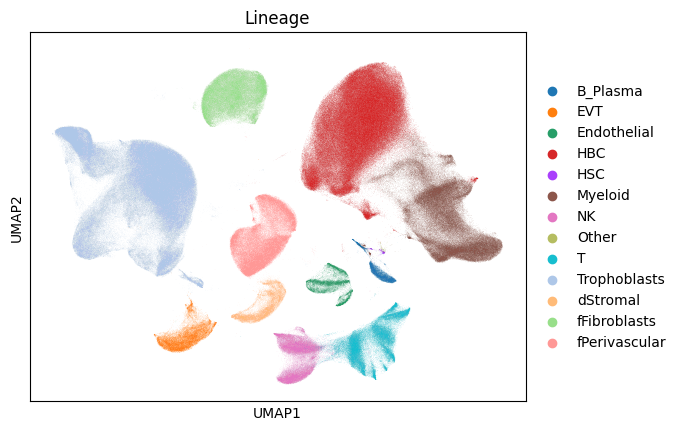

In [385]:
sc.pl.umap(sc_obj,color = "Lineage")

## find overlap

In [ ]:
shared_features = [
    feature for feature in TMA_obj.var_names if feature in sc_obj.var_names
]


In [ ]:
len(shared_features)

In [ ]:
TMA_obj = TMA_obj[:, shared_features].copy()

In [ ]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/visium_data")
TMA_obj.write_h5ad("TMA_merged_b2c_V3.h5ad")

# Filter genes
use the top genes from each sublineage

# Setup main dict 

In [ ]:
all_clusts_merge = {}

## Main obj 

### load obj 

In [206]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/ref_data/PB_scObj_V11")
main_obj = an.read_h5ad("scObj_V11.h5ad")

In [256]:
main_obj

AnnData object with n_obs × n_vars = 1228981 × 34812
    obs: 'Sample', 'Batch', 'n_genes', 'n_counts', 'percent_mito', 'Lineage', 'sub-lineage2', 'leiden_res_0.5', 'Condition', 'Fetal_sex', 'Maternal_age', 'Labor', 'GA_delivery', 'DeliveryMode', 'Fetal_growth_restriction', 'Birthweight_percentile', 'Hypertensive_disorder', 'PrePreg_BMI', 'Cytowash', 'Over3h_cytowah', 'status', 'assignment', 'FetMat_Annotation', 'sub_lin', 'sub_lin2', 'Main_lin_num'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Lineage_colors', 'PCs', '_attr2type', 'de_lineage', 'genome', 'leiden_resolution', 'modality', 'pca', 'pca_features', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std', 'uid'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices'
    varm: 'de_final', 'de_res_0.5'
    layers: 'norm_counts'
    obsp: 'W_pca', 'W_pca_harmony'

### get dic 

In [294]:
pb_dict_main = pd.read_excel("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/ref_data/PB_scObj_V11/scObj_V11_ova_with_pb.xlsx", sheet_name=None)

### make into dict 

In [295]:
main_obj_dic = {'main_obj' : main_obj, 'pb_dic' : pb_dict_main , 'label_col':'Lineage', 'cluster_col':'Main_lin_num'}


## Trophoblasts - intermediat lin


### load obj 

In [210]:
os.chdir("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Trophoblasts/PB_Trophoblast_V2_0.5/troph_rd1_0.5/RD2_Troph_webbrowser")
trop_obj = mu.read("RD2_Troph_V6.h5mu")

### get dic

In [296]:
pb_dict_troph = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Trophoblasts/PB_Trophoblast_V2_0.5/troph_rd1_0.5/RD2_Troph_webbrowser/RD2_Troph_webbrowser_NO_MATERNAL/PB_RD2_Troph_V7/OVA_markers_final_GEX.xlsx", sheet_name=None)

### load into dict

In [297]:
troph_obj_dic = {'main_obj' :trop_obj["GEX"], 'pb_dic' : pb_dict_troph, 'label_col':'sub_lin', 'cluster_col':'sub_lin_num'}

## Troph - RD3B fine cluster

### load obj

In [463]:
sub_troph_RD3B= mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Trophoblasts/PB_Trophoblast_V2_0.5/troph_rd1_0.5/sub_VCT_fusion_res07_clust4/RD3B_Troph_webbrowser/RD3B_Troph_web_NoMat/RD3B_Troph_V6.h5mu")

In [465]:
sub_troph_RD3B["GEX"].obs

,Sample,Batch,n_genes,n_counts,percent_mito,Condition,FetalSex,Labor,GA_delivery,Over3hrs_in_cytowash,...,Cytowash,Fetal_sex,Over3h_cytowah,status,assignment,FetMat_Annotation,sub_lin,sub_lin2,sub_lin2_num,final_clusters
barcodekey,,,,,,,,,,,,,,,,,,,,,
AAACCTCCAACAGCGG-1-BMP-0039-Batch4,BMP-0039,Batch4,2125,9723.0,5.646405,FGR,Female,Yes,41.1,Over3hrs_in_cytowash,...,No,Female,No,singlet,0,Fetal,VCTfusion,VCTfusion_2,2,2
AAACGGAGTCAGTGCA-1-BMP-0039-Batch4,BMP-0039,Batch4,3590,25552.0,3.987946,FGR,Female,Yes,41.1,Over3hrs_in_cytowash,...,No,Female,No,singlet,0,Fetal,VCTfusion,VCTfusion_1,1,1
AAACGGCCAGGTAAGC-1-BMP-0039-Batch4,BMP-0039,Batch4,2178,5119.0,1.640946,FGR,Female,Yes,41.1,Over3hrs_in_cytowash,...,No,Female,No,singlet,0,Fetal,VCTfusion,VCTfusion_1,1,1
AAAGCTAAGCGTCTAA-1-BMP-0039-Batch4,BMP-0039,Batch4,2844,9654.0,7.582349,FGR,Female,Yes,41.1,Over3hrs_in_cytowash,...,No,Female,No,singlet,0,Fetal,VCTfusion,VCTfusion_1,1,1
AAATCCGTCAATTCGG-1-BMP-0039-Batch4,BMP-0039,Batch4,3925,19952.0,4.190056,FGR,Female,Yes,41.1,Over3hrs_in_cytowash,...,No,Female,No,singlet,0,Fetal,VCTfusion,VCTfusion_1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTGGTTCAAATTGAA-1-BMP-0187-Batch15,BMP-0187,Batch15,5108,34379.0,3.557404,PTB (GA Controls),NaN,No,35.0,Over3hrs_in_cytowash,...,No,Male,No,singlet,0,Fetal,VCTfusion,VCTfusion_1,1,1
GTTGTAAGTGTATCCC-1-BMP-0187-Batch15,BMP-0187,Batch15,2273,7916.0,5.255179,PTB (GA Controls),NaN,No,35.0,Over3hrs_in_cytowash,...,No,Male,No,singlet,0,Fetal,VCTfusion,VCTfusion_2,2,2
GTTGTGCAGAACGTGG-1-BMP-0187-Batch15,BMP-0187,Batch15,4041,15276.0,4.346688,PTB (GA Controls),NaN,No,35.0,Over3hrs_in_cytowash,...,No,Male,No,singlet,0,Fetal,VCTfusion,VCTfusion_1,1,1


### load PB

In [464]:
Troph3B_PB = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Trophoblasts/PB_Trophoblast_V2_0.5/troph_rd1_0.5/sub_VCT_fusion_res07_clust4/RD3B_Troph_webbrowser/RD3B_Troph_web_NoMat/PB_RD3B_Troph_V6/RD3B_Troph_V6_ova_with_pb.xlsx",sheet_name=None)

### make into dict

In [466]:
Troph3B_dic = {'main_obj' :sub_troph_RD3B["GEX"], 'pb_dic' :Troph3B_PB, 'label_col':'sub_lin2', 'cluster_col':'sub_lin2_num'}

## Tropph RD3A Fine cluster

### load obj

In [470]:
sub_troph_RD3A = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Trophoblasts/PB_Trophoblast_V2_0.5/troph_rd1_0.5/PB_Trophoblast_V3_0.7/troph_sub_rd2/RD3A_Troph_webbrowser/RD3A_Troph_web_noMat/RD3A_Troph_V6.h5mu")

### load PB

In [471]:
Troph3A_PB = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Trophoblasts/PB_Trophoblast_V2_0.5/troph_rd1_0.5/PB_Trophoblast_V3_0.7/troph_sub_rd2/RD3A_Troph_webbrowser/RD3A_Troph_web_noMat/PB_RD3A_Troph_V6/RD3A_Troph_V6_ova_with_pb.xlsx",sheet_name=None)

### make into dict

In [472]:
Troph3A_dic = {'main_obj' :sub_troph_RD3A["GEX"], 'pb_dic' :Troph3A_PB, 'label_col':'sub_lin2', 'cluster_col':'sub_lin2_num'}

## EVT

### load obj 

In [213]:
os.chdir("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/EVT/RD1_EVT_webbrowser")
evt_obj = mu.read("RD1_EVT_V5.h5mu")

### get pb info 

In [298]:
pb_dict_evt = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/EVT/RD1_EVT_webbrowser/PB_RD1_EVT_V5/OVA_markers_final_GEX.xlsx", sheet_name=None)

### make into dict

In [299]:
evt_obj_dic = {'main_obj' :evt_obj["GEX"], 'pb_dic' : pb_dict_evt, 'label_col':'sub_lin', 'cluster_col':'sub_lin_num'}


## HBC

### load obj 

In [300]:
hbc_obj = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Myeloid/HBC/HBC_V4.h5mu")


In [304]:
hbc_obj['GEX'].obs['sub_lin'] = "HBC" + hbc_obj['GEX'].obs['final_clusters'].astype(str)


### load PB results 

In [301]:
pb_dict_hbc = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Myeloid/HBC/PB_HBC_V4/HBC_V4_ova_with_pb.xlsx", sheet_name=None)

### make into dict

In [309]:
hbc_obj_dic = {'main_obj' :hbc_obj["GEX"], 'pb_dic' : pb_dict_hbc, 'label_col':'sub_lin', 'cluster_col':'final_clusters'}


## dStromal (full)

### load obj 

In [313]:
dS_obj = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Decidual_stromal/RD1_dS_webbrowser/RD1_dS_webbrowser_NO_FETAL/RD1_dS_V6.h5mu")

In [316]:
dS_obj["GEX"].obs

,Sample,Batch,Condition,Fetal_sex,Labor,GA_delivery,Lineage,sub-lineage2,Maternal_age,DeliveryMode,...,PrePreg_BMI,Cytowash,Over3h_cytowah,sub_lin2,sub_lin,status,assignment,FetMat_Annotation,sub_lin_num,final_clusters
barcodekey,,,,,,,,,,,,,,,,,,,,,
AAGCATCGTGGTACTG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS2_2,dS2,singlet,1,Maternal,2,2
AAGCTCATCGGTTACA-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS3,dS3,singlet,1,Maternal,3,3
AATACGAAGCTTAAGT-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS2_2,dS2,singlet,1,Maternal,2,2
AATATTCCAATTACCA-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS2_3,dS2,singlet,1,Maternal,2,2
ACAGCTATCGGTAGCT-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS2_2,dS2,singlet,1,Maternal,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTCGTTTCGCAAAGG-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Decidual_stromal,NaN,39,Cesarean section,...,34,No,No,dS2_1,dS2,singlet,1,Maternal,2,2
GTTCTATGTAGGATAG-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Decidual_stromal,NaN,39,Cesarean section,...,34,No,No,dS1_1,dS1,singlet,1,Maternal,1,1
GTTGACATCGGCTCGA-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Decidual_stromal,NaN,39,Cesarean section,...,34,No,No,dS1_1,dS1,singlet,1,Maternal,1,1


### load PB dict 

In [314]:
pb_dict_dS = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Decidual_stromal/RD1_dS_webbrowser/RD1_dS_webbrowser_NO_FETAL/PB_RD1_dS_V6/RD1_dS_V6_ova_with_pb.xlsx", sheet_name=None)

### make into dict 

In [ ]:
dS_obj_dic = {'main_obj':dS_obj["GEX"], 'pb_dic': pb_dict_dS,'label_col': 'sub_lin','cluster_col':'sub_lin_num' }

## dS1

### load obj

In [479]:
dS1_obj = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Decidual_stromal/PB_RD1_decidual_stromal_GEX_0.7/RD2_DS/PB_RD2_DS_GEX_0.5/RD3A_DS/RD3A_dS1_webbrowser/RD3A_dS1_V4.h5mu")

In [481]:
dS1_obj['GEX'].obs

,Sample,Batch,Condition,Fetal_sex,Labor,GA_delivery,Lineage,sub-lineage2,Maternal_age,DeliveryMode,...,PrePreg_BMI,Cytowash,Over3h_cytowah,sub_lin2,sub_lin,status,assignment,FetMat_Annotation,sub_lin2_num,final_clusters
barcodekey,,,,,,,,,,,,,,,,,,,,,
ACTCACTTCAATATTG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS1_1,-,singlet,1,Maternal,1,1
AGGCTCGTCCCTTCAG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS1_2,-,singlet,1,Maternal,2,2
AGGGCGAGTAGGCAGG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS1_1,-,singlet,1,Maternal,1,1
ATTCGACCAACGTTTA-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS1_1,-,singlet,1,Maternal,1,1
CCAAGTATCCATTCAC-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS1_1,-,singlet,1,Maternal,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTCGTTTCCTAGCCC-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Decidual_stromal,NaN,39,Cesarean section,...,34,No,No,dS1_1,-,singlet,1,Maternal,1,1
GTTCTATGTAGGATAG-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Decidual_stromal,NaN,39,Cesarean section,...,34,No,No,dS1_1,-,singlet,1,Maternal,1,1
GTTGACATCGGCTCGA-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Decidual_stromal,NaN,39,Cesarean section,...,34,No,No,dS1_1,-,singlet,1,Maternal,1,1


### load PB

In [480]:
dS1_PB = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Decidual_stromal/PB_RD1_decidual_stromal_GEX_0.7/RD2_DS/PB_RD2_DS_GEX_0.5/RD3A_DS/RD3A_dS1_webbrowser/PB_RD3A_dS1_V4/RD3A_dS1_V4_ova_with_pb.xlsx",sheet_name=None)

### make into dict

In [482]:
dS1_obj_dic = {'main_obj':dS1_obj["GEX"], 'pb_dic': dS1_PB,'label_col': 'sub_lin2','cluster_col':'sub_lin2_num' }

In [485]:
dS1_obj["GEX"]

AnnData object with n_obs × n_vars = 11040 × 25935
    obs: 'Sample', 'Batch', 'Condition', 'Fetal_sex', 'Labor', 'GA_delivery', 'Lineage', 'sub-lineage2', 'Maternal_age', 'DeliveryMode', 'Fetal_growth_restriction', 'Birthweight_percentile', 'Hypertensive_disorder', 'PrePreg_BMI', 'Cytowash', 'Over3h_cytowah', 'sub_lin2', 'sub_lin', 'status', 'assignment', 'FetMat_Annotation', 'sub_lin2_num', 'final_clusters'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'PCs', '_attr2type', 'final_clusters_colors', 'genome', 'leiden_resolution', 'modality', 'pca', 'pca_features', 'status_colors', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std', 'sub_lin2_colors', 'uid'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_before_harmony', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'pca_knn_distances', 'pca_knn_indices'
    varm: 'de_final'
    layers: 'norm_counts'
    obsp: 'W_pca', 'W_pca_harmony'

## dS2

### load obj

In [490]:
dS2_obj = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Decidual_stromal/PB_RD1_decidual_stromal_GEX_0.7/RD2_DS/PB_RD2_DS_GEX_0.5/RD3B_DS/RD3B_dS2_webbrowser/RD3B_dS2_web_no_fetal/RD3B_dS2_V6.h5mu")

In [492]:
dS2_obj["GEX"].obs

,Sample,Batch,Condition,Fetal_sex,Labor,GA_delivery,Lineage,sub-lineage2,Maternal_age,DeliveryMode,...,PrePreg_BMI,Cytowash,Over3h_cytowah,sub_lin2,sub_lin,status,assignment,FetMat_Annotation,sub_lin2_num,final_clusters
barcodekey,,,,,,,,,,,,,,,,,,,,,
AAGCATCGTGGTACTG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS2_2,dS2,singlet,1,Maternal,2,2
AATACGAAGCTTAAGT-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS2_2,dS2,singlet,1,Maternal,2,2
AATATTCCAATTACCA-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS2_3,dS2,singlet,1,Maternal,3,3
ACAGCTATCGGTAGCT-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS2_2,dS2,singlet,1,Maternal,2,2
ACAGTTAGTGCTAGTG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Decidual_stromal,Stromal_9,33,Vaginal delivery,...,25,No,No,dS2_1,dS2,singlet,1,Maternal,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGTCTAATCCTGGGTG-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Decidual_stromal,NaN,39,Cesarean section,...,34,No,No,dS2_1,dS2,singlet,1,Maternal,1,1
GTACCTTTCATGGGCT-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Decidual_stromal,NaN,39,Cesarean section,...,34,No,No,dS2_1,dS2,singlet,1,Maternal,1,1
GTATCGGGTCGACTCT-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Decidual_stromal,NaN,39,Cesarean section,...,34,No,No,dS2_1,dS2,singlet,1,Maternal,1,1


### load PB

In [498]:
dS2_PB = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Decidual_stromal/PB_RD1_decidual_stromal_GEX_0.7/RD2_DS/PB_RD2_DS_GEX_0.5/RD3B_DS/RD3B_dS2_webbrowser/RD3B_dS2_web_no_fetal/PB_RD3B_dS2_V6/RD3B_dS2_V6_ova_with_pb.xlsx",sheet_name=None)

### make into dict

In [499]:
dS2_dict = {'main_obj':dS2_obj["GEX"], 'pb_dic': dS2_PB,'label_col': 'sub_lin2','cluster_col':'sub_lin2_num' }

## dS4

### load obj

In [504]:
dS4_obj = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Decidual_stromal/PB_RD1_decidual_stromal_GEX_0.7/RD2_DS/PB_RD2_DS_GEX_0.5/RD3C_DS/RD3C_dS4_webbrowser/RD3C_dS4_web_no_fetal/RD3C_dS4_V5.h5mu")

### load PB

In [505]:
dS4_PB = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Decidual_stromal/PB_RD1_decidual_stromal_GEX_0.7/RD2_DS/PB_RD2_DS_GEX_0.5/RD3C_DS/RD3C_dS4_webbrowser/RD3C_dS4_web_no_fetal/PB_RD3C_dS4_V5/RD3C_dS4_V5_ova_with_pb.xlsx",sheet_name=None)

### make into dict

In [506]:
dS4_dict = {'main_obj':dS4_obj["GEX"], 'pb_dic': dS4_PB,'label_col': 'sub_lin2','cluster_col':'sub_lin2_num' }

## sub_PAMMS

### load obj 

In [321]:
PAMMS_main = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Myeloid/Maternal_mixed/sub_main_PAMMs/sub_PAMMs_V4.h5mu")

In [327]:
PAMMS_main["GEX"].obs

,Sample,Batch,Condition,Fetal_sex,Labor,GA_delivery,Lineage,sub-lineage2,Maternal_age,DeliveryMode,...,Birthweight_percentile,Hypertensive_disorder,PrePreg_BMI,Cytowash,Over3h_cytowah,status,assignment,FetMat_Annotation,final_clusters,sub_lin
barcodekey,,,,,,,,,,,,,,,,,,,,,
AAACCAAAGAAGGTGT-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Myeloid,Maternal_myeloid,33,Vaginal delivery,...,7,No,25,No,No,singlet,0,Fetal,2,mPAMM2
AAACCCATCAAAGCAA-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Myeloid,Maternal_myeloid,33,Vaginal delivery,...,7,No,25,No,No,singlet,0,Fetal,2,mPAMM2
AAACCCATCATTACAA-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Myeloid,Maternal_myeloid,33,Vaginal delivery,...,7,No,25,No,No,singlet,1,Maternal,8,mPAMM8
AAACCCATCGTCAATG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Myeloid,Maternal_myeloid,33,Vaginal delivery,...,7,No,25,No,No,singlet,0,Fetal,7,mPAMM7
AAACCGACACGACCTA-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Myeloid,Maternal_myeloid,33,Vaginal delivery,...,7,No,25,No,No,singlet,0,Fetal,3,mPAMM3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTGGTTCAATTCGTA-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Myeloid,NaN,39,Cesarean section,...,12,No,34,No,No,singlet,0,Fetal,2,mPAMM2
GTTGTAAGTCGATTGG-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Myeloid,NaN,39,Cesarean section,...,12,No,34,No,No,singlet,1,Maternal,1,mPAMM1
GTTGTCCGTGCGAATT-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Myeloid,NaN,39,Cesarean section,...,12,No,34,No,No,singlet,1,Maternal,4,mPAMM4


In [325]:
PAMMS_main['GEX'].obs['sub_lin'] = "mPAMM" + PAMMS_main['GEX'].obs['final_clusters'].astype(str)


### load PB

In [322]:
pb_dict_PAMM_main = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Myeloid/Maternal_mixed/sub_main_PAMMs/PB_sub_PAMMs_V4/sub_PAMMs_V4_ova_with_pb.xlsx", sheet_name=None)

### make into dict 

In [328]:
mPAMM_obj_dic = {'main_obj' : PAMMS_main["GEX"], 'pb_dic' : pb_dict_PAMM_main , 'label_col':'sub_lin', 'cluster_col':'final_clusters'}


## mixed PAMMS

### load obj 

In [332]:
upper_PAMM = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Myeloid/Maternal_mixed/sub_mixed_upper/sub_upper_mixed_V4.h5mu")

In [338]:
upper_PAMM["GEX"].obs

,Sample,Batch,Condition,Fetal_sex,Labor,GA_delivery,Lineage,sub-lineage2,Maternal_age,DeliveryMode,...,Birthweight_percentile,Hypertensive_disorder,PrePreg_BMI,Cytowash,Over3h_cytowah,status,assignment,FetMat_Annotation,final_clusters,sub_lin
barcodekey,,,,,,,,,,,,,,,,,,,,,
AAACGGCCAGGCATTT-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Myeloid,HBC2:HLA-DPA1_CX3CR1,33,Vaginal delivery,...,7,No,25,No,No,singlet,0,Fetal,1,uPAMM1
AAACTACTCCGGTTAA-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Myeloid,Maternal_myeloid,33,Vaginal delivery,...,7,No,25,No,No,singlet,0,Fetal,3,uPAMM3
AAAGCGCCAGGTATCT-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Myeloid,Maternal_myeloid,33,Vaginal delivery,...,7,No,25,No,No,singlet,0,Fetal,4,uPAMM4
AAAGGAACAACCCCAA-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Myeloid,HBC2:HLA-DPA1_CX3CR1,33,Vaginal delivery,...,7,No,25,No,No,singlet,0,Fetal,1,uPAMM1
AACACCCAGCCGCTAG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Myeloid,Maternal_myeloid,33,Vaginal delivery,...,7,No,25,No,No,singlet,0,Fetal,4,uPAMM4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTGTGATGTCTAGTGG-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Myeloid,NaN,39,Cesarean section,...,12,No,34,No,No,singlet,1,Maternal,1,uPAMM1
GTTGGTCAGCAAAGCG-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Myeloid,NaN,39,Cesarean section,...,12,No,34,No,No,singlet,1,Maternal,1,uPAMM1
GTTGGTTCAACATCAC-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Myeloid,NaN,39,Cesarean section,...,12,No,34,No,No,singlet,1,Maternal,1,uPAMM1


In [336]:
upper_PAMM['GEX'].obs['sub_lin'] = "uPAMM" + upper_PAMM['GEX'].obs['final_clusters'].astype(str)


### load PB dict 

In [333]:
pb_uPAMM = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Myeloid/Maternal_mixed/sub_mixed_upper/PB_sub_upper_mixed_V4/sub_upper_mixed_V4_ova_with_pb.xlsx",sheet_name=None)

### make into dict 

In [340]:
uPAMM_obj_dic = {'main_obj' : upper_PAMM["GEX"], 'pb_dic' : pb_uPAMM , 'label_col':'sub_lin', 'cluster_col':'final_clusters'}


### DC 

### load obj 

In [349]:
DC_obj = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Myeloid/Maternal_mixed/sub_DCs/sub_DCs_V3.h5mu")

In [351]:
DC_obj['GEX'].obs['sub_lin'] = "DC" + DC_obj['GEX'].obs['final_clusters'].astype(str)


### get PB results 

In [352]:
pb_DC = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Myeloid/Maternal_mixed/sub_DCs/PB_sub_DCs_V3/sub_DCs_V3_ova_with_pb.xlsx",sheet_name=None)

### make into dict 

In [353]:
DC_obj_dic = {'main_obj' : DC_obj["GEX"], 'pb_dic' : pb_DC , 'label_col':'sub_lin', 'cluster_col':'final_clusters'}


## T cells 

### load obj 

In [358]:
T_obj = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/T_NK/T_only/T_V6.h5mu")

In [365]:
T_obj["GEX"].obs

,Sample,Batch,Condition,Fetal_sex,Labor,GA_delivery,Lineage,sub-lineage2,Maternal_age,DeliveryMode,...,Birthweight_percentile,Hypertensive_disorder,PrePreg_BMI,Cytowash,Over3h_cytowah,final_clusters,status,assignment,FetMat_Annotation,sub_lin
barcodekey,,,,,,,,,,,,,,,,,,,,,
AAACCAGCACAGGACG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,T_NK,T_activated,33,Vaginal delivery,...,7,No,25,No,No,5,singlet,1,Maternal,mixedT_cycling
AAACCCCAGACTGTTG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,T_NK,T_activated,33,Vaginal delivery,...,7,No,25,No,No,4,singlet,1,Maternal,mCD8_act
AAACCGGAGCACCCGA-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,T_NK,T_activated,33,Vaginal delivery,...,7,No,25,No,No,2,singlet,1,Maternal,mCD8_eff_GZMK
AAACCTCCAGTAGGCG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,T_NK,T_activated,33,Vaginal delivery,...,7,No,25,No,No,2,singlet,1,Maternal,mCD8_eff_GZMK
AAACGATCACATCATA-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,T_NK,T_activated,33,Vaginal delivery,...,7,No,25,No,No,5,singlet,1,Maternal,mixedT_cycling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTCTAGAGAAGCTAA-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,T_NK,NaN,39,Cesarean section,...,12,No,34,No,No,6,singlet,1,Maternal,mTreg
GTTCTAGAGCAATATC-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,T_NK,NaN,39,Cesarean section,...,12,No,34,No,No,1,singlet,1,Maternal,mCD4_eff
GTTCTCAGTGTTCTCA-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,T_NK,NaN,39,Cesarean section,...,12,No,34,No,No,1,singlet,1,Maternal,mCD4_eff


### load PB 

In [371]:
pb_T = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/T_NK/T_only/PB_T_V5/T_V5_ova_with_pb.xlsx",sheet_name=None)

In [446]:
pb_T['12|up']

,featurekey,log2Mean,log2Mean_other,log2FC,percentage,percentage_other,percentage_fold_change,auroc,mwu_U,mwu_pval,mwu_qval,pseudobulk_log_fold_change,pseudobulk_p_val,pseudobulk_adj_p_val
0,G:KLRB1,8.347,1.736,6.610,90.344002,20.827999,4.338000,0.870,71162363.5,0.000000,0.000000,2.731,0.000,0.000
1,G:SLC4A10,2.978,0.022,2.956,40.998001,0.323000,127.027000,0.703,57530349.5,0.000000,0.000000,3.101,0.000,0.000
2,G:CEBPD,3.566,0.574,2.992,46.727001,8.069000,5.791000,0.696,56923062.5,0.000000,0.000000,2.382,0.000,0.000
3,G:IL7R,7.959,4.424,3.536,87.889000,49.002998,1.794000,0.696,56901359.5,0.000000,0.000000,1.307,0.000,0.003
4,G:TRAV1-2,2.385,0.144,2.241,33.470001,1.895000,17.665001,0.657,53765558.5,0.000000,0.000000,2.469,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,G:AC087286.2,0.004,0.001,0.003,0.082000,0.007000,10.953000,0.500,40920968.5,0.006047,0.042202,-0.002,0.714,0.941
1755,G:LINC01873,0.004,0.001,0.003,0.082000,0.007000,10.953000,0.500,40920968.5,0.006047,0.042202,0.013,0.465,0.941
1756,G:LRRN4CL,0.005,0.001,0.004,0.082000,0.007000,10.953000,0.500,40920968.5,0.006047,0.042202,0.011,0.389,0.941
1757,G:ARTN,0.003,0.001,0.003,0.082000,0.007000,10.953000,0.500,40920968.5,0.006047,0.042202,-0.002,0.763,0.941


### make into dict 

In [372]:
T_obj_dic = {'main_obj' : T_obj["GEX"], 'pb_dic' : pb_T , 'label_col':'sub_lin', 'cluster_col':'final_clusters'}


## NK cells 

### load obj 

In [377]:
NK_obj = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/T_NK/NK_only/NK_V5.h5mu")

### Load PB results 

In [378]:
pb_NK = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/T_NK/NK_only/PB_NK_V4/NK_V4_ova_with_pb.xlsx",sheet_name=None)


### make into dict 

In [379]:
NK_obj_dic = {'main_obj' : NK_obj["GEX"], 'pb_dic' : pb_NK , 'label_col':'sub_lin', 'cluster_col':'final_clusters'}


## Endothelial cells - intermediate lineages

### load obj 

In [397]:
endo_obj = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Endothelial/RD1_webbrowser/RD1_webbrowser_NO_FETAL_MAT_DOUBLET/RD1_Endo_V5.h5mu")

In [399]:
endo_obj["GEX"].obs

,Sample,Batch,Condition,Fetal_sex,Labor,GA_delivery,Lineage,sub-lineage2,Maternal_age,DeliveryMode,...,PrePreg_BMI,Cytowash,Over3h_cytowah,sub_lin2,sub_lin,status,assignment,FetMat_Annotation,sub_lin_num,final_clusters
barcodekey,,,,,,,,,,,,,,,,,,,,,
AAACCGCTCGTAGTTG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_m2,Endo_m,singlet,1,Maternal,2,2
AAACCTCCACATCTCC-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_f1,Endo_f,singlet,0,Fetal,1,1
AAAGGGGCACCTGTAG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_f3,Endo_f,singlet,0,Fetal,1,1
AAATTGGAGAGGCTGA-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_f1,Endo_f,singlet,0,Fetal,1,1
AACATGGCACTAAGCT-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_f1,Endo_f,singlet,0,Fetal,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTGTCGAGTGGCTCCC-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Endothelial,NaN,39,Cesarean section,...,34,No,No,Endo_m1,Endo_m,singlet,1,Maternal,2,2
GTTACCCGTCGTCTTA-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Endothelial,NaN,39,Cesarean section,...,34,No,No,Endo_m1,Endo_m,singlet,1,Maternal,2,2
GTTCGCTGTAGGCCCG-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Endothelial,NaN,39,Cesarean section,...,34,No,No,Endo_m1,Endo_m,singlet,1,Maternal,2,2


### load PB

In [398]:
endo_PB = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Endothelial/RD1_webbrowser/RD1_webbrowser_NO_FETAL_MAT_DOUBLET/PB_RD1_Endo_V5/RD1_Endo_V5_ova_with_pb.xlsx",sheet_name=None)

### merge into dict

In [400]:
endo_obj_dic = {'main_obj' : endo_obj["GEX"], 'pb_dic' : endo_PB , 'label_col':'sub_lin', 'cluster_col':'final_clusters'}

## EndoF (more granular)

### load obj

In [447]:
endo_f_obj = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Endothelial/PB_RD1_Endo_GEX_0.7/RD2A_Endo/RD2A_endo_f_webbrowser/RD2A_endoF_web_NoMAT/RD2A_Endo_f_V5.h5mu")

In [449]:
endo_f_obj['GEX'].obs

,Sample,Batch,Condition,Fetal_sex,Labor,GA_delivery,Lineage,sub-lineage2,Maternal_age,DeliveryMode,...,PrePreg_BMI,Cytowash,Over3h_cytowah,sub_lin2,sub_lin,status,assignment,FetMat_Annotation,sub_lin2_num,final_clusters
barcodekey,,,,,,,,,,,,,,,,,,,,,
AAACCTCCACATCTCC-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_f1,Endo_f,singlet,0,Fetal,1,1
AAAGGGGCACCTGTAG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_f3,Endo_f,singlet,0,Fetal,3,3
AAATTGGAGAGGCTGA-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_f1,Endo_f,singlet,0,Fetal,1,1
AACATGGCACTAAGCT-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_f1,Endo_f,singlet,0,Fetal,1,1
AACCAATTCATGTAGT-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_f1,Endo_f,singlet,0,Fetal,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTACGGTTCGTCCATT-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Endothelial,NaN,39,Cesarean section,...,34,No,No,Endo_f3,Endo_f,singlet,0,Fetal,3,3
GTAGCGTTCCATAGGC-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Endothelial,NaN,39,Cesarean section,...,34,No,No,Endo_f1,Endo_f,singlet,0,Fetal,1,1
GTAGGGTCAGGTTTAC-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Endothelial,NaN,39,Cesarean section,...,34,No,No,Endo_f2,Endo_f,singlet,0,Fetal,2,2


### load PB obj

In [448]:
endo_f_PB = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Endothelial/PB_RD1_Endo_GEX_0.7/RD2A_Endo/RD2A_endo_f_webbrowser/RD2A_endoF_web_NoMAT/PB_RD2A_Endo_f_V5/RD2A_Endo_f_V5_ova_with_pb.xlsx",sheet_name=None)

### merge into dict

In [450]:
endoF_dic = {'main_obj' : endo_f_obj["GEX"], 'pb_dic' : endo_f_PB , 'label_col':'sub_lin2', 'cluster_col':'final_clusters'}


## EndoM (more granular)

### load obj

In [455]:
EndoM_obj = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Endothelial/PB_RD1_Endo_GEX_0.7/RD2B_Endo/RD2B_endo_m_webbrowser/RD2B_endoM_web_NoFetal/RD2B_Endo_m_V5.h5mu")

In [457]:
EndoM_obj["GEX"].obs

,Sample,Batch,Condition,Fetal_sex,Labor,GA_delivery,Lineage,sub-lineage2,Maternal_age,DeliveryMode,...,PrePreg_BMI,Cytowash,Over3h_cytowah,sub_lin2,sub_lin,status,assignment,FetMat_Annotation,sub_lin2_num,final_clusters
barcodekey,,,,,,,,,,,,,,,,,,,,,
AAACCGCTCGTAGTTG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_m2,Endo_m,singlet,1,Maternal,2,2
ACCATCGCAGTCGCAC-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_m1,Endo_m,singlet,1,Maternal,1,1
ACGAGGCAGAAGCGGC-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_m2,Endo_m,singlet,1,Maternal,2,2
AGTGATCGTCTTGGAG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_m2,Endo_m,singlet,1,Maternal,2,2
ATCCCTAGTGTACGTG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Endothelial,Endothelial,33,Vaginal delivery,...,25,No,No,Endo_m2,Endo_m,singlet,1,Maternal,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTGTCGAGTGGCTCCC-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Endothelial,NaN,39,Cesarean section,...,34,No,No,Endo_m1,Endo_m,singlet,1,Maternal,1,1
GTTACCCGTCGTCTTA-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Endothelial,NaN,39,Cesarean section,...,34,No,No,Endo_m1,Endo_m,singlet,1,Maternal,1,1
GTTCGCTGTAGGCCCG-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Endothelial,NaN,39,Cesarean section,...,34,No,No,Endo_m1,Endo_m,singlet,1,Maternal,1,1


### Read PB

In [456]:
EndoM_PB = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Endothelial/PB_RD1_Endo_GEX_0.7/RD2B_Endo/RD2B_endo_m_webbrowser/RD2B_endoM_web_NoFetal/PB_RD2B_Endo_m_V5/RD2B_Endo_m_V5_ova_with_pb.xlsx",sheet_name=None)

### Make into dict

In [458]:
endoM_dic = {'main_obj' : EndoM_obj["GEX"], 'pb_dic' : EndoM_PB , 'label_col':'sub_lin2', 'cluster_col':'final_clusters'}


## fetal fibroblasts

### load obj

In [511]:
fFB_main = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Stromal/RD1_fFB_webbrowser/RD1_fFB_webbrowser_NO_MATERNAL/RD1_fFB_V5.h5mu")

In [513]:
fFB_main["GEX"].obs

,Sample,Batch,Condition,Fetal_sex,Labor,GA_delivery,Lineage,sub-lineage2,Maternal_age,DeliveryMode,...,PrePreg_BMI,Cytowash,Over3h_cytowah,sub_lin,sub_lin2,status,assignment,FetMat_Annotation,sub_lin_num,final_clusters
barcodekey,,,,,,,,,,,,,,,,,,,,,
AAACCCCAGCATTAGT-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Stromal,S2_TCF21,33,Vaginal delivery,...,25,No,No,fFB3,fFB3_1,unassigned,0/1,NaN,3,3
AAACCGGAGACGTTAT-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Stromal,S2_TCF21,33,Vaginal delivery,...,25,No,No,fFB1,fFB1,singlet,0,Fetal,1,1
AAACGATCACGAACGG-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Stromal,S2_TCF21,33,Vaginal delivery,...,25,No,No,fFB2,fFB2,singlet,0,Fetal,2,2
AAACGTAAGCTAGCTA-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Stromal,S2_TCF21,33,Vaginal delivery,...,25,No,No,fFB1,fFB1,singlet,0,Fetal,1,1
AAACTGCGTAGAGGGT-1-BMP-0039-Batch4,BMP-0039,Batch4,FGR,Female,Yes,41.1,Stromal,S2_TCF21,33,Vaginal delivery,...,25,No,No,fFB1,fFB1,singlet,0,Fetal,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTCATCTCACCAACA-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Stromal,NaN,39,Cesarean section,...,34,No,No,fFB2,fFB2,singlet,0,Fetal,2,2
GTTCATCTCATGACCA-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Stromal,NaN,39,Cesarean section,...,34,No,No,fFB1,fFB1,singlet,0,Fetal,1,1
GTTCGGGTCCTCAGCC-1-BMP-0187-Batch15,BMP-0187,Batch15,PTB (GA Controls),Male,No,35.0,Stromal,NaN,39,Cesarean section,...,34,No,No,fFB3,fFB3_1,singlet,0,Fetal,3,3


### load PB

In [512]:
fFB_PB = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Stromal/RD1_fFB_webbrowser/RD1_fFB_webbrowser_NO_MATERNAL/PB_RD1_fFB_V5/RD1_fFB_V5_ova_with_pb.xlsx",sheet_name=None)

### make into dict

In [514]:
fFB_dic = {'main_obj' : fFB_main["GEX"], 'pb_dic' : fFB_PB , 'label_col':'sub_lin', 'cluster_col':'final_clusters'}


## fFB3 sub

### load obj

In [521]:
fFB3_obj = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Stromal/PB_RD1_stromal_GEX_0.7/RD2A_Stromal/PB_RD2_stromal_GEX_0.3/RD3Aa_stromal/PB_RD3Aa_stromal_GEX_0.3/RD4Aa_stromal/RD4A_fFB3_webbrowser/RD4A_fFB3_web_no_mat/RD4A_fFB3_V5.h5mu")

### load PB

In [522]:
fFB3_PB = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Stromal/PB_RD1_stromal_GEX_0.7/RD2A_Stromal/PB_RD2_stromal_GEX_0.3/RD3Aa_stromal/PB_RD3Aa_stromal_GEX_0.3/RD4Aa_stromal/RD4A_fFB3_webbrowser/RD4A_fFB3_web_no_mat/PB_RD4A_fFB3_V5/RD4A_fFB3_V5_ova_with_pb.xlsx",sheet_name=None)

### make into dict

In [523]:
fFB3_dic = {'main_obj' : fFB3_obj["GEX"], 'pb_dic' : fFB3_PB , 'label_col':'sub_lin2', 'cluster_col':'final_clusters'}


## fFB5 sub

In [527]:
fFB5_obj = mu.read("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Stromal/PB_RD1_stromal_GEX_0.7/RD2A_Stromal/PB_RD2_stromal_GEX_0.3/RD3Ac_stromal/RD3B_fFB4_webbrowser/RD3B_fFB4_web_noMat/RD3B_fFB4_V5.h5mu")

### load PB

In [528]:
fFB5_PB = pd.read_excel("/projects/Pregnancy_placenta/Results/11_Subclustering_B1-15/Stromal/PB_RD1_stromal_GEX_0.7/RD2A_Stromal/PB_RD2_stromal_GEX_0.3/RD3Ac_stromal/RD3B_fFB4_webbrowser/RD3B_fFB4_web_noMat/PB_RD3B_fFB4_V5/RD3B_fFB4_V5_ova_with_pb.xlsx",sheet_name=None)

### make into dict

In [529]:
fFB4_dic = {'main_obj' : fFB5_obj["GEX"], 'pb_dic' : fFB5_PB , 'label_col':'sub_lin2', 'cluster_col':'final_clusters'}


## fPV main

# Testing different criterea

In [368]:
key

'Tcells'

## merging all objs into dictionary

In [473]:
all_clusts_merge = {'main': main_obj_dic,
                    "troph":troph_obj_dic,
                    "sub_troph_3A":Troph3A_dic,
                    "sub_troph_3B":Troph3B_dic,
                    "evt":evt_obj_dic,
                    "hbc":hbc_obj_dic,
                    "dS":dS_obj_dic,
                    "dS1":dS1_PB,
                    'main_PAMM':mPAMM_obj_dic,
                    'upper_PAMM':uPAMM_obj_dic,
                    "DC":DC_obj_dic,
                    "Tcells":T_obj_dic,
                    "NK":NK_obj_dic,
                    "Endo":endo_obj_dic,
                    "EndoF":endoF_dic,
                    "EndoM":endoM_dic}

In [530]:
all_clusts_merge = {"fFB":fFB_dic,
                    "fFB3":fFB3_dic,
                    "fFB4":fFB4_dic}

## TEST 1 (AUROC of 0.7)

In [531]:
df_num_genes = pd.DataFrame()
all_marker_const = pd.DataFrame()

for key,value in all_clusts_merge.items():
    print(f"{key}")
    adata_obj = all_clusts_merge[key]['main_obj']
    temp_dic = all_clusts_merge[key]['pb_dic']
    
    temp_label_col = all_clusts_merge[key]['label_col']
    temp_cluster_col = all_clusts_merge[key]['cluster_col']
    
    temp_marker = scRNAseq_func.get_marker_genes_from_pb_V2(adata_obj,
                         temp_dic,criterea_int="auroc",fc_thresh = 0.7,label_col = temp_label_col, cluster_col = temp_cluster_col,
                                                            min_expr_thresh = None)
    
    # merge all clusters into one dataframe
    all_marker_const = pd.concat([all_marker_const, temp_marker], ignore_index=True)

    
    # How many markers in cluster
    df_num_marker = temp_marker['cell_type'].value_counts()
    df_num_marker_df = df_num_marker.reset_index()
    df_num_marker_df.columns = ['cell_type', 'count']
    df_num_marker_df['parent_lin'] = key
    df_num_genes  = pd.concat([df_num_genes, df_num_marker_df], ignore_index=True)
    
    # 
   # print(f"{key}")

fFB
fFB3
fFB4


In [517]:
len(all_marker_const['gene'].unique())

298

### get a sense of the unique genes distinguishing main lineaeges

In [ ]:
main_obj_dic['main_obj'].obs["Lineage"].unique()

In [415]:
all_marker_const['cell_type'].isin([])

0                     HBC
1                     HBC
2                     HBC
3                     HBC
4                     HBC
              ...        
4700                 mNKT
4701    fNKT_PRDM16_KLRC4
4702    fNKT_PRDM16_KLRC4
4703    fNKT_PRDM16_KLRC4
4704    fNKT_PRDM16_KLRC4
Name: cell_type, Length: 4705, dtype: object

In [436]:
lin_int = main_obj_dic['main_obj'].obs["Lineage"].cat.categories
len(all_marker_const[all_marker_const['cell_type'].isin(lin_int)]['gene'].unique())
#all_marker_const[all_marker_const['gene']=="S100A9"]

1840

### Plot Ns

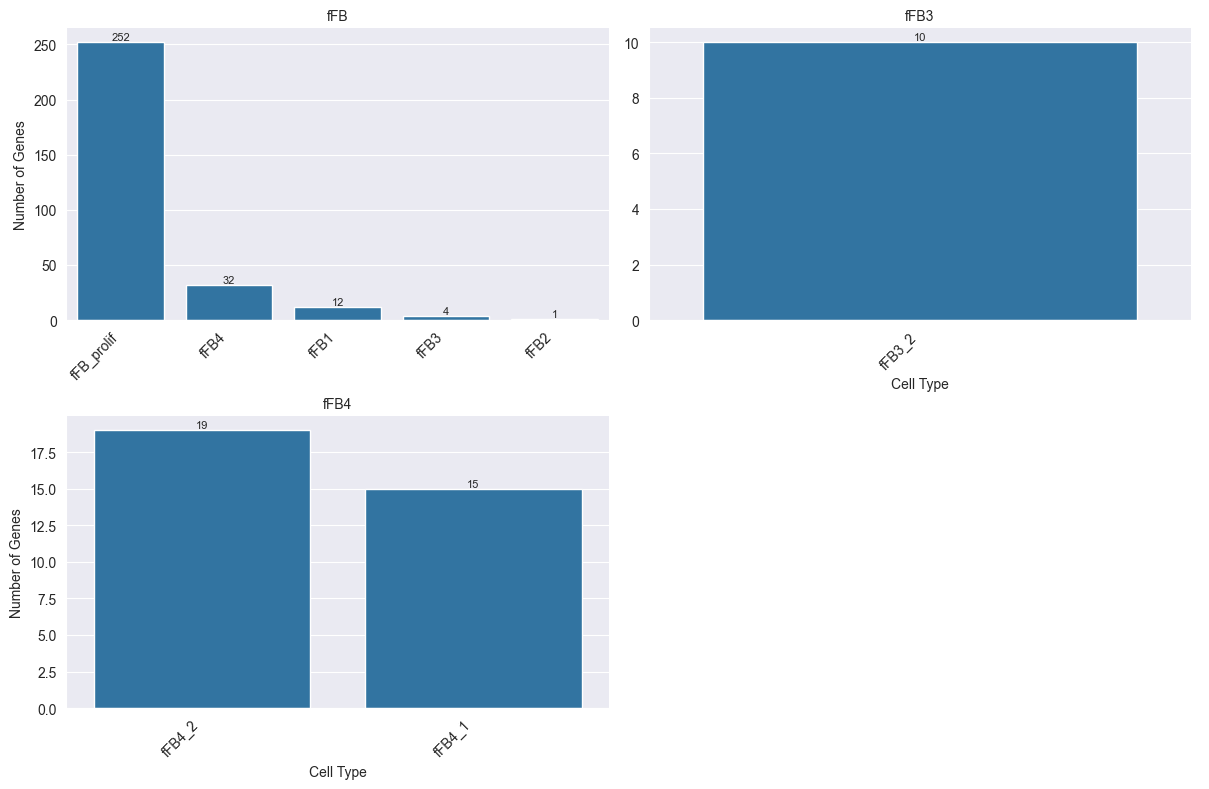

In [532]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.catplot(
    data=df_num_genes,
    x='cell_type', y='count',
    col='parent_lin',
    kind='bar',
    col_wrap=2, height=4, aspect=1.5,
    sharex=False,
    sharey=False
)

g.set_xticklabels(rotation=45, ha='right')
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Cell Type", "Number of Genes")

# Add value labels above bars
for ax in g.axes.flatten():
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{int(height)}',
                ha='center', va='bottom',
                fontsize=8
            )

plt.tight_layout()
plt.show()


In [519]:
df_num_genes

,cell_type,count,parent_lin
0,fFB_prolif,252,fFB
1,fFB4,32,fFB
2,fFB1,12,fFB
3,fFB3,4,fFB
4,fFB2,1,fFB


In [478]:
all_marker_const[all_marker_const['cell_type'].isin(["VCTp_3"])]

,cell_type,gene
3052,VCTp_3,STMN1
3053,VCTp_3,HMGB2
3054,VCTp_3,TUBA1B
3055,VCTp_3,TYMS
3056,VCTp_3,HMGB1
3057,VCTp_3,TUBB
3058,VCTp_3,H2AFZ
3059,VCTp_3,NUSAP1
3060,VCTp_3,UBE2C
3061,VCTp_3,MT2A


In [520]:
all_marker_const


,cell_type,gene
0,fFB1,CXCL14
1,fFB1,VCAN
2,fFB1,HAPLN1
3,fFB1,BMP5
4,fFB1,TCF21
...,...,...
296,fFB_prolif,KHDRBS1
297,fFB_prolif,NDUFA2
298,fFB_prolif,LMNA
299,fFB_prolif,LIG1


In [238]:
df_num_marker_df = df_num_marker.reset_index()
df_num_marker_df.columns = ['cell_type', 'count']


In [231]:
df_num_marker['parent_lin'] = 'evt'

In [244]:
df_num_marker_df

,cell_type,count,parent_lin
0,EVT5,5,evt
1,EVT1,2,evt
2,EVT4,2,evt
3,EVT6,1,evt


# IGNORE

In [204]:
evt_marker = scRNAseq_func.get_marker_genes_from_pb(evt_obj["GEX"],
                         pb_dict,criterea_int="auroc",fc_thresh = 0.8)

# Get DE for Lineages of main obj 

## load and find De of objects 

In [ ]:
os.chdir("/projects/Pregnancy_placenta/Results/10_Merging_all_batches/")
adata = mu.read("Batches1-15_V11.h5mu")

In [ ]:
sc_obj = adata["GEX"]

In [ ]:
sc_obj.var_names = sc_obj.var_names.str.replace('^G:', '', regex=True)

In [ ]:
sc.tl.rank_genes_groups(sc_obj, groupby='Lineage', method="wilcoxon",key_added="de_lineage",use_raw=False)

## save into excel sheet

In [193]:
temp_ALL_df = sc.get.rank_genes_groups_df(sc_obj, group=None, key='de_lineage', pval_cutoff=0.05, log2fc_min=None)


In [194]:
temp_ALL_df 

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,B_Plasma,CD79A,179.487915,14.633451,0.0,0.0
1,B_Plasma,MS4A1,158.861771,13.193179,0.0,0.0
2,B_Plasma,CD52,139.582275,7.173305,0.0,0.0
3,B_Plasma,IGHM,133.707321,12.807725,0.0,0.0
4,B_Plasma,CD37,131.697891,5.880999,0.0,0.0
...,...,...,...,...,...,...
165637,fPerivascular,ARPC1B,-297.100342,-4.936180,0.0,0.0
165638,fPerivascular,CD55,-298.205505,-8.036880,0.0,0.0
165639,fPerivascular,DAB2,-303.707733,-6.580072,0.0,0.0
165640,fPerivascular,VAMP8,-311.065765,-5.373387,0.0,0.0


In [195]:
# get a lsit of the unique clusters
for temp_clust in sc_obj.obs['Lineage'].unique():
    temp_clust_df = temp_ALL_df[temp_ALL_df['group'] == temp_clust]
    dict_name = temp_clust
    df_OVA_list[dict_name] = temp_clust_df

NameError: name 'df_OVA_list' is not defined

## save obj 

In [ ]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/ref_data")
sc_obj.write_h5ad("Batches1-15_V11_RANK_GENES.h5ad")

## get DE list 

In [189]:
scRNAseq_func.get_DEG_cluster_list_OVA(sc_obj,clust_int = "Lineage" )

did not perform sc.tl.rank_genes_groups. redo


()

In [192]:
re.search(r"[\d\.]+$", "Lineage")

In [191]:
import re